# Step 0: Set up visualisation, import libraries

In [1]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# visualising parameters
colour_map = 'jet'
resolution = 50

def get_plotting_domain(domain):
    x = torch.linspace(domain.bounds[0][0], domain.bounds[1][0], resolution)
    y = torch.linspace(domain.bounds[0][1], domain.bounds[1][1], resolution)
    x_grid, y_grid = torch.meshgrid(x, y)
    X_grid = torch.dstack([x_grid, y_grid]).reshape(resolution**2, 2)
    return X_grid

def plot_function(data, ax):
    data = data.detach().numpy().reshape(resolution, resolution)
    image = ax.imshow(
        data,
        cmap=plt.get_cmap(colour_map),
        vmin=data.min(),
        vmax=data.max(),
        extent=[domain.bounds[0][1], domain.bounds[1][1], domain.bounds[0][0], domain.bounds[1][0]],
        interpolation='nearest',
        origin='lower',
    )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(image, cax=cax)
    
def plot_white(X, ax):
    X = X.numpy() # transform to numpy
    ax.scatter(X[:,1], X[:,0], s=50, color="white")

def plot_gold(X, ax):
    X = X.numpy() # transform to numpy
    ax.scatter(X[:,1], X[:,0], s=50, marker="+", color="gold")

# Step 1: Problem definition
- Target funciton: Ackley
- task: minimization
- dimension: 2
- bounds: [-1, 1]^d
- global minimum: 0

In [3]:
import botorch
from utils._experiments import FunctionWrapper
from utils._domain import UniformDomain

n_dims = 2               # Number of dimension
dtype = torch.float64    # data type
noise_std = None         # noise variance in f feedback

bounds = torch.vstack([-1 * torch.ones(n_dims), 1 * torch.ones(n_dims)]).to(dtype)
domain = UniformDomain(bounds)
_test_function = botorch.test_functions.Ackley(
    dim=n_dims,          # number of dimensions
    noise_std=noise_std, # noiseless feedback
    negate=False,         # minimisation problem
)
global_minimum = 0
global_maximum = 3.6253849384403627
test_function = FunctionWrapper(_test_function, global_minimum, global_maximum, dtype)

# Step 2. Set up initial dataset
### 2.1 set up f dataset

/opt/anaconda3/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


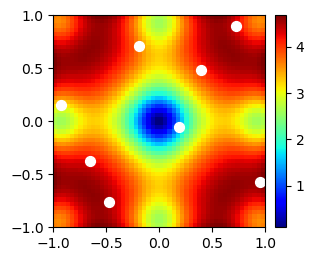

In [5]:
torch.manual_seed(0)

n_init = 8 # number of initial random f samples
train_X = domain.sample(n_init)
train_Y = test_function(train_X)

fig, ax = plt.subplots(1,1, figsize=(3,3))
Xgrid = get_plotting_domain(domain)
Ygrid = test_function(Xgrid)
plot_function(Ygrid, ax)
plot_white(train_X, ax)

### 2.2. Set up synthetic agent response
Synthetic human response function is defined in Example 2.2.

In [8]:
from utils._synthetic_agent import SyntheticAgentResponse

n_init_agent = 10   # number of initial agent samples
a = 1               # feedback accuracy (a>0 helpful, a=0 random, a<0 adversarial)

agent = SyntheticAgentResponse(test_function, a=a)
train_X_agent, train_Y_agent = agent.sample(domain, n_init_agent, balanced=True)

train_Y_agent are binary labels from human.<br>
You can use real human response instead.

In [10]:
train_Y_agent

tensor([0., 1., 1., 1., 1., 1., 0., 0., 0., 0.], dtype=torch.float64)

# Step 3. Set up surrogate models
### 3.1 Gaussian process model for objective belief model f

Text(0.5, 1.0, 'predictive stddev')

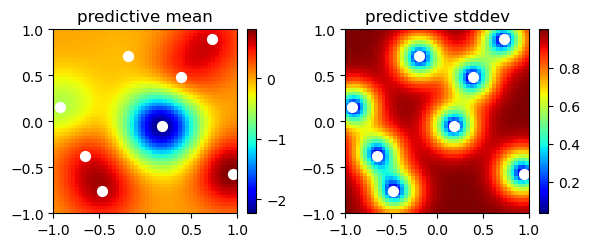

In [16]:
from utils._gaussian_process import SimpleGP

# Set up GP
model = SimpleGP(train_X, train_Y, domain)
model.train(train_X, train_Y)

# visualize current posterior
Ypred, stddev = model.predictive_mean_and_stddev(Xgrid, transform=True)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,3), tight_layout=True)
plot_function(Ypred, ax1)
plot_white(train_X, ax1)
ax1.set_title("predictive mean")
plot_function(stddev, ax2)
plot_white(train_X, ax2)
ax2.set_title("predictive stddev")

### 3.2 Likelihood ratio model for subjective belief model g

In [19]:
from utils._likelihood_ratio import LikelihoodRatioConfidenceSetModel

# Set up likelihood ratio model
g_lb = -3          # upper bound of g value
g_ub = 3           # lower bound of g value
beta_coeff = 0.01  # initial beta value
g_norm_bound = 1   # initial RKHS norm estimate

model_const = LikelihoodRatioConfidenceSetModel(
    train_X_agent, train_Y_agent, domain, 
    kernel=model.gp.covar_module, 
    g_lb=g_lb,
    g_ub=g_ub,
    beta_coeff=beta_coeff,
    g_norm_bound=g_norm_bound,
)
model_const.train(train_X_agent, train_Y_agent)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Updated. norm_2 and alpha 0.02
Updated. norm_4 and alpha 0.04
Updated. norm_8 and alpha 0.08
Updated. norm_16 and alpha 0.16


### Visualise the subjective belief model
prediciton takes times a bit, because it needs to solve optimizaiton problem at each location.<br>
For resolution= 50, it needs to solve 50 * 50 * 3 = 7,500 optimizations.<br>
In acquisition function minimization, it needs much less times.

Text(0.5, 1.0, 'predictive UCB')

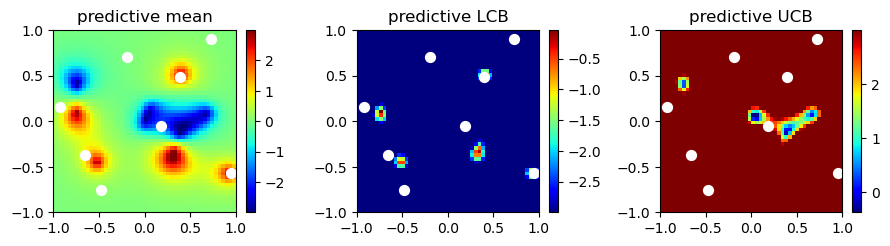

In [22]:
gpred, g_lcb, g_ucb = model_const.predictive_distribution(Xgrid, transform=True)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3), tight_layout=True)
plot_function(gpred, ax1)
plot_white(train_X, ax1)
ax1.set_title("predictive mean")
plot_function(g_lcb, ax2)
plot_white(train_X, ax2)
ax2.set_title("predictive LCB")
plot_function(g_ucb, ax3)
plot_white(train_X, ax3)
ax3.set_title("predictive UCB")

# Step 4: Solve Bayesian Optimization
### 4.1 initialization

In [23]:
from utils._cobol import COBOL

T = 100       # number of iterations
eta = 3.      # trust weight
g_thr = 1e-2  # handover guarantee threshold
dual_var = 1. # primal dual weights

cobol = COBOL(
        model, 
        model_const, 
        T, 
        trust_weight=eta, 
        g_thr=g_thr,
        dual_var=dual_var,
)
cobol.initialisation(train_X, train_Y, train_X_agent, train_Y_agent)

### 4.2 Running COBOL algorithm

In [24]:
results = []
for t in range(1, 1+T):
    X_next, flag_query_agent = cobol.query(t)
    if flag_query_agent:
        print("Asking agents...")
        Y_agent_next = agent(X_next)
        train_X_agent = torch.vstack([train_X_agent, X_next])
        train_Y_agent = torch.cat([train_Y_agent, Y_agent_next])
        cobol.model_const.train(train_X_agent, train_Y_agent)
        if Y_agent_next == 0:
            Y_next = test_function(X_next)
            train_X = torch.vstack([train_X, X_next])
            train_Y = torch.cat([train_Y, Y_next])
            cobol.model.train(train_X, train_Y)
            cobol.model_const.kernel_initialisation(cobol.model.gp.covar_module)
    else:
        Y_next = test_function(X_next)
        train_X = torch.vstack([train_X, X_next])
        train_Y = torch.cat([train_Y, Y_next])
        cobol.model.train(train_X, train_Y)
        cobol.model_const.kernel_initialisation(cobol.model.gp.covar_module)

    N_query = len(train_Y_agent) - n_init_agent
    N_func = len(train_Y) - n_init
    Y_best = train_Y.min().item()
    results.append([t, N_query, N_func, Y_best])
    print('Iter: %d N_query_agent: %d N_query_function: %d best found: %.3f ' % (t, N_query, N_func, Y_best))
results = torch.tensor(results)

Augmented BO is selected
Asking agents...
Iter: 1 N_query_agent: 1 N_query_function: 1 best found: 1.291 
Augmented BO is selected
Asking agents...
Iter: 2 N_query_agent: 2 N_query_function: 1 best found: 1.291 
Augmented BO is selected
Asking agents...
Iter: 3 N_query_agent: 3 N_query_function: 1 best found: 1.291 
Augmented BO is selected
Asking agents...
Iter: 4 N_query_agent: 4 N_query_function: 2 best found: 1.291 
Augmented BO is selected
Asking agents...
Iter: 5 N_query_agent: 5 N_query_function: 3 best found: 1.236 
Augmented BO is selected
Asking agents...
Iter: 6 N_query_agent: 6 N_query_function: 4 best found: 1.236 
Augmented BO is selected
Asking agents...
Iter: 7 N_query_agent: 7 N_query_function: 4 best found: 1.236 
Augmented BO is selected
Asking agents...
Updated. norm_32 and alpha 0.32
Iter: 8 N_query_agent: 8 N_query_function: 4 best found: 1.236 
Augmented BO is selected
Asking agents...
Iter: 9 N_query_agent: 9 N_query_function: 4 best found: 1.236 
Augmented BO i

### 4.3 Results

Text(0.5, 1.0, 'query convergence')

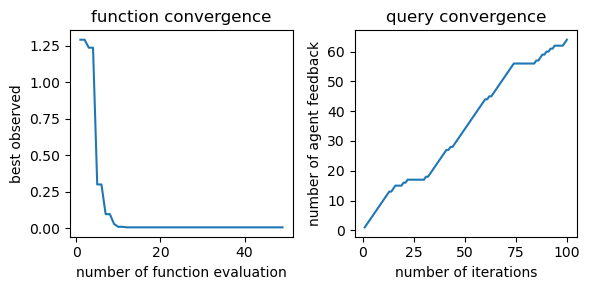

In [36]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,3), tight_layout=True)

ax1.plot(results[:,2], results[:,3])
ax1.set_xlabel("number of function evaluation")
ax1.set_ylabel("best observed")
ax1.set_title("function convergence")

ax2.plot(results[:,0], results[:,1])
ax2.set_xlabel("number of iterations")
ax2.set_ylabel("number of agent feedback")
ax2.set_title("query convergence")